In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

TODO: Gill & Suisted 1978 Coli data.
TODO: add data from Lewis et al. 1992 on Algae?
TODO: add data from Hunter & Rose on Yeast?

In [2]:
# Read and analyze Marr et al. Coli fatty-acid data. 
marr_conds = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='conditions', index_col=0)
marr_fas = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='fatty_acids', index_col=1)
marr_data = pd.read_excel('../data/lipids/Coli/Marr1962_JBac.xlsx', sheet_name='tables_1_2_3',
                          index_col=1).replace({np.NaN: 0, '': 0}).infer_objects()

In [3]:
# Grab the relevant data and convert to a long-form dataframe. Values are in weight percent. 
marr_data_long = marr_data.reset_index().melt(
    id_vars='short_name', value_vars=marr_data.columns[1:], var_name='condition', value_name='weight_percent')

# Add NC, MW and NOSC information to the long-form DF
NC = marr_fas.loc[marr_data_long.short_name].NC.values
mw = marr_fas.loc[marr_data_long.short_name].mw_daltons.values
NOSC = marr_fas.loc[marr_data_long.short_name].NOSC.values

marr_data_long['NC'] = NC
marr_data_long['mw_daltons'] = mw
marr_data_long['NOSC'] = NOSC

# Calculate the fraction of lipid C atoms on each molecule
# Convert to carbon units and then rescale. 
marr_data_long['C_fraction'] = marr_data_long.weight_percent*NC/mw
C_sums = marr_data_long.groupby('condition').sum().C_fraction
marr_data_long.C_fraction /= C_sums.loc[marr_data_long.condition].values

# Save the long-form version
marr_data_long.to_csv('../data/lipids/Coli/Marr1962_JBac_long.csv', index=False)

In [4]:
# Fraction of C atoms x NOSC is related to total valence e- on that lipid.
# The sum of these terms is just the total lipid NOSC. 
marr_data_long['lipid_NOSC'] = marr_data_long.C_fraction * marr_data_long.NOSC

# Calculate the per-sample total lipid NOSC (with all the assumptions)
total_lipids_nosc = marr_data_long.groupby('condition').agg(dict(lipid_NOSC='sum'))
total_lipids_nosc['growth_rate_hr'] = marr_conds.loc[total_lipids_nosc.index].growth_rate_hr.values
total_lipids_nosc['temp_C'] = marr_conds.loc[total_lipids_nosc.index].temp_C.values
total_lipids_nosc['experiment'] = marr_conds.loc[total_lipids_nosc.index].experiment.values

total_lipids_nosc.to_csv('../data/lipids/Coli/Marr1962_total_lipids_NOSC.csv')
total_lipids_nosc.head()

,lipid_NOSC,growth_rate_hr,temp_C,experiment
condition,,,,
10_C,-1.661453,NaN,10,temp
10_C_rich,-1.660531,NaN,10,temp_rich
15_C,-1.664918,NaN,15,temp
20_C,-1.670111,NaN,20,temp
20_C_rich,-1.665985,NaN,20,temp_rich


<AxesSubplot: xlabel='growth_rate_hr', ylabel='lipid_NOSC'>

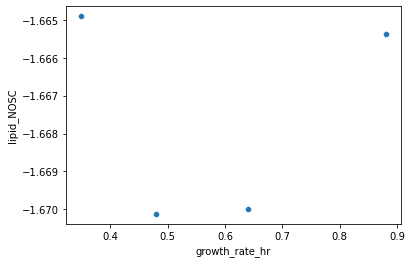

In [5]:
sns.scatterplot(data=total_lipids_nosc, x='growth_rate_hr', y='lipid_NOSC')

<AxesSubplot: xlabel='temp_C', ylabel='lipid_NOSC'>

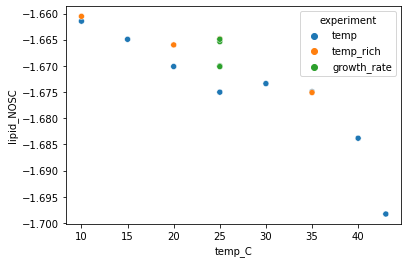

In [6]:
sns.scatterplot(data=total_lipids_nosc, x='temp_C', y='lipid_NOSC', hue='experiment')